In [1]:
"""
Notebook that runs grid searches for different neural network sizes find best hyperparameters 
with prices of options on the Amazon (AMZN) stock obtained from barchart.com,
then trains the models with those parameters and evaluates the performance on unseen data
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow import keras
from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from math import floor
from datetime import date
from time import time

data_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\Neural-Network-Option-Pricing-Master-Thesis\\Code\\OptionData\\'
result_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\Neural-Network-Option-Pricing-Master-Thesis\\Code\\Results\\'
plot_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\LaTeX Template\\'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
lwidth = 1

np.random.seed(seed=123)
set_seed(1234)

# 1 Prepare Data

## 1.1 Load Data

In [2]:
asof = date(2022, 3, 15) # date of obtained close prices
maturities = [date(2022, 7, 15), date(2023, 3, 17), date(2024, 1, 19)]

T = {}
for d in maturities:
    T[np.round((d - asof).days / 365, 2)] = d
print('Times to expiration')
print(list(T.keys()))

s0 = 2947.33
print('AMZN close price at {}'.format(asof))
print(s0)

Times to expiration
[0.33, 1.01, 1.85]
AMZN close price at 2022-03-15
2947.33


In [3]:
"""
Train-test split for each maturity
"""
X = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}

for t in T:
    df = pd.read_csv(data_path + 'amzn-options-exp-{}-monthly-show-all-stacked-03-16-2022.csv'.format(T[t]))
    df = df[df['Type'] == 'Call']
    df['Strike'] = df['Strike'].apply(lambda x: float(x.replace(',', '')))
    df['Midpoint'] = df['Midpoint'].apply(lambda x: float(x.replace(',', '')))
    df = df[['Strike', 'Midpoint']]
    df['Option Norm'] = df['Midpoint'] / df['Strike']
    df['Stock Norm'] = s0 / df['Strike']
    X[t] = np.array(df['Stock Norm']).reshape((len(df), 1))
    y[t] = np.array([df['Option Norm']]).reshape((len(df), 1))
    X_train[t], X_test[t], y_train[t], y_test[t] = train_test_split(X[t], y[t], test_size=0.2)
    print('T = {}'.format(t))
    print('Number of data points: Train: {} Test {}'.format(len(X_train[t]), len(X_test[t])))

T = 0.33
Number of data points: Train: 137 Test 35
T = 1.01
Number of data points: Train: 74 Test 19
T = 1.85
Number of data points: Train: 124 Test 31


## 1.2 Plot Data

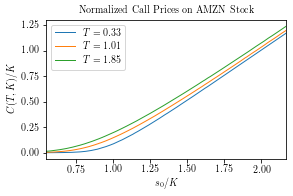

In [4]:
fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_subplot()
fig.tight_layout()
ax.margins(x=0)
for t in T:
    ax.plot(X[t], y[t], label='$T={}$'.format(t), lw=lwidth)
ax.set_xlabel('$s_0/K$', fontsize=10)
ax.set_ylabel('$C(T,K)/K$', fontsize=10)
ax.set_title('Normalized Call Prices on AMZN Stock', fontsize=10)
plt.legend(fontsize=10)
plt.savefig(plot_path + 'AMZN_Prices.pdf')

# 2 Grid Search

## 2.1 Helper Functions

In [5]:
"""
Helper function to create model from given number of weights and hidden layers
"""

def create_model(hidden_layers=1, learning_rate=0.001, n_weights=10):
    # formulas derived from nWeights = sum (d(l-1)+1)*d(l) for all layers l with output dim d(l)
    
    if hidden_layers == 1: # 100% of neurons in first hidden layer
        neurons = [floor((n_weights - 1) / 3)]
    elif hidden_layers == 2: # 70% / 30% split of neurons
        x = 1/7 * (np.sqrt(21 * n_weights + 79) - 10)
        neurons = list(map(floor,[7/3 * x, x]))
    elif hidden_layers == 3: # 50% / 30% / 20% split
        x = 1/21 * (np.sqrt(84 * n_weights + 205) - 17)
        neurons = list(map(floor, [5/2 * x, 3/2 * x, x]))
    else:
        raise Exception('Only 1, 2 or 3 layers allowed')
        
    model = Sequential([Dense(neurons[0], activation='relu', input_dim=1)])
    for n in neurons[1:]:
        model.add(Dense(n, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model


In [6]:
"""
Runs grid search for given train and test data with network of given size
"""

def run_grid_search(X_train, y_train, n_weights, n_epochs):
    
    batch_size = [8, 16, 32, 64]
    learning_rate = [0.1, 0.01, 0.001, 0.0001]
    hidden_layers = [1, 2, 3]

    p_grid = dict(hidden_layers=hidden_layers, batch_size=batch_size, learning_rate=learning_rate, epochs=n_epochs)
    
    def creator(hidden_layers, learning_rate): return create_model(hidden_layers, learning_rate, n_weights)
    
    model = KerasRegressor(creator, verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=p_grid, n_jobs=-1, cv=4, verbose=3)
    grid_result = grid.fit(X_train, y_train)
    print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
    return grid_result

In [7]:
"""
Saves performance result for all parameters and best results for each network size
"""

def save_results(result_dict, maturity):

    columns = ['mean_fit_time', 'param_batch_size', 'param_hidden_layers', 'param_learning_rate', 
                'param_epochs', 'mean_test_score', 'rank_test_score']
    dfs = []
    best_dfs = []
    for n in result_dict.keys():
        df = pd.DataFrame(result_dict[n].cv_results_)[columns]
        df['n_weights'] = n
        df.columns = ['Training Time (s)', 'Batch Size', 'Hidden Layers', 'Learning Rate', 'Epochs',
                      'Validation MSE', 'Rank', 'Weights']
        df = df[['Weights', 'Validation MSE', 'Hidden Layers', 'Learning Rate', 'Batch Size',
                 'Epochs', 'Training Time (s)', 'Rank']]
        df['Validation MSE'] = (-df['Validation MSE']).apply(lambda x: '{:.3e}'.format(x))
        dfs.append(df)
        best_dfs.append(df[df['Rank'] == 1].drop(['Rank'], axis=1))
    result_df = pd.concat(dfs).reset_index(drop=True)
    best_result_df = pd.concat(best_dfs).reset_index(drop=True)
    result_df.to_csv(result_path + 'one_dim_AMZN_{}_grid_search_all_results.csv'.format(maturity), index=False)
    best_result_df.to_csv(result_path + 'one_dim_AMZN_{}_grid_search_overview.csv'.format(maturity), index=False)
    return best_result_df

## 2.1 Perform Grid Search

In [8]:
n_epochs = {10: [10, 25, 50, 100],
               30: [10, 25, 50, 100],
               60: [10, 25, 50, 100],
               100: [10, 25, 50, 100],
               300: [20, 50, 100, 150],
               600: [20, 50, 100, 150],
               1000: [20, 50, 100, 150],
               3000: [50, 100, 150, 200],
               6000: [50, 100, 150, 200],
               10000: [50, 100, 175, 300],
               30000: [100, 175, 300, 500]}

n_weights = n_epochs.keys()

In [ ]:
results = {}
for t in T:
    print('T = {}'.format(t))
    results[t] = {}
    for n in n_weights:
        print('Network Size = {}'.format(n))
        results[t][n] = run_grid_search(X_train[t], y_train[t], n, n_epochs[n])
    results[t] = save_results(results[t], t)
    display(results[t])

T = 0.33
Network Size = 10
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -0.0009674137281763251 using {'batch_size': 16, 'epochs': 25, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 30
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -0.0001920194954436738 using {'batch_size': 8, 'epochs': 100, 'hidden_layers': 1, 'learning_rate': 0.01}
Network Size = 60
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -2.044089796982007e-05 using {'batch_size': 16, 'epochs': 25, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 100
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -3.798362843099312e-05 using {'batch_size': 16, 'epochs': 50, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 300
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -5.226648113421106e-06 using {'batch_size': 64, 'epochs': 150, 'hidden_layers': 3, 'learning_rate': 0.01}
Network Size = 600
Fitting 4 fo

,Weights,Validation MSE,Hidden Layers,Learning Rate,Batch Size,Epochs,Training Time (s)
0,10,9.674e-04,1,0.1,16,25,1.494752
1,30,1.920e-04,1,0.01,8,100,3.416613
2,60,2.044e-05,1,0.1,16,25,1.406987
3,100,3.798e-05,1,0.1,16,50,1.611690
4,300,5.227e-06,3,0.01,64,150,2.093899
5,600,6.483e-06,3,0.001,8,150,6.163267
6,1000,5.710e-06,3,0.001,8,150,6.535271
7,3000,7.818e-07,1,0.01,8,200,7.358070
8,6000,6.540e-07,1,0.01,64,200,2.982524
9,10000,3.323e-07,1,0.01,64,175,3.511858


T = 1.01
Network Size = 10
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -0.0035686590999830514 using {'batch_size': 16, 'epochs': 10, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 30
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -0.0002678500441106735 using {'batch_size': 16, 'epochs': 50, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 60
Fitting 4 folds for each of 192 candidates, totalling 768 fits


C:\Users\oli-w\anaconda3\envs\tensorflow\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: -5.507345758815063e-05 using {'batch_size': 8, 'epochs': 50, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 100
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -1.8458411148003506e-05 using {'batch_size': 8, 'epochs': 25, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 300
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -2.909075033130648e-05 using {'batch_size': 8, 'epochs': 100, 'hidden_layers': 2, 'learning_rate': 0.01}
Network Size = 600
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -1.6063458588178037e-05 using {'batch_size': 8, 'epochs': 150, 'hidden_layers': 3, 'learning_rate': 0.01}
Network Size = 1000
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -6.453494052038877e-06 using {'batch_size': 8, 'epochs': 50, 'hidden_layers': 3, 'learning_rate': 0.01}
Network Size = 3000
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -2.6494131759591255e-06 using 

,Weights,Validation MSE,Hidden Layers,Learning Rate,Batch Size,Epochs,Training Time (s)
0,10,3.569e-03,1,0.1,16,10,1.759793
1,30,2.679e-04,1,0.1,16,50,1.543621
2,60,5.507e-05,1,0.1,8,50,1.720898
3,100,1.846e-05,1,0.1,8,25,1.956019
4,300,2.909e-05,2,0.01,8,100,2.725959
5,600,1.606e-05,3,0.01,8,150,4.058894
6,1000,6.453e-06,3,0.01,8,50,2.056500
7,3000,2.649e-06,3,0.001,8,150,4.132697
8,6000,1.585e-06,3,0.01,32,100,2.077693
9,10000,3.965e-07,1,0.01,32,300,3.576184


T = 1.85
Network Size = 10
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -0.0012094256526324898 using {'batch_size': 8, 'epochs': 25, 'hidden_layers': 1, 'learning_rate': 0.01}
Network Size = 30
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -0.00018042039664578624 using {'batch_size': 16, 'epochs': 100, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 60
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -2.61035288531275e-05 using {'batch_size': 64, 'epochs': 100, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 100
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -3.568811121112958e-05 using {'batch_size': 8, 'epochs': 25, 'hidden_layers': 1, 'learning_rate': 0.1}
Network Size = 300
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -1.7045175127350376e-05 using {'batch_size': 8, 'epochs': 100, 'hidden_layers': 3, 'learning_rate': 0.01}
Network Size = 600
Fitting 4 fo

C:\Users\oli-w\anaconda3\envs\tensorflow\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: -9.471754879086802e-06 using {'batch_size': 32, 'epochs': 100, 'hidden_layers': 3, 'learning_rate': 0.01}
Network Size = 1000
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -3.5491095218276314e-06 using {'batch_size': 8, 'epochs': 150, 'hidden_layers': 1, 'learning_rate': 0.01}
Network Size = 3000
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -1.1145138003598731e-06 using {'batch_size': 32, 'epochs': 100, 'hidden_layers': 1, 'learning_rate': 0.01}
Network Size = 6000
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -9.865632364380872e-07 using {'batch_size': 32, 'epochs': 150, 'hidden_layers': 1, 'learning_rate': 0.01}
Network Size = 10000
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Best: -2.1598921673415816e-07 using {'batch_size': 64, 'epochs': 175, 'hidden_layers': 1, 'learning_rate': 0.01}
Network Size = 30000
Fitting 4 folds for each of 192 candidates, totalling 768 fits


# Run Models on Test Data

In [9]:
"""
Trains and evaluates all models with best parameters (from grid search) for a given pricing model and maturity
with early stopping
"""
from time import time

def run_tests(df_overview, X_train, y_train, X_test, y_test, maturity):
    test_mse = []
    train_epochs = []
    train_time = []
    earlyStop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)    
    for weights, hidden, lr, batch in zip(df_overview['Weights'], df_overview['Hidden Layers'], 
                                          df_overview['Learning Rate'], df_overview['Batch Size']):
        model = create_model(hidden, float(lr), weights)
        start = time()
        hist = model.fit(X_train, y_train, epochs=5000, batch_size=batch, verbose=0, callbacks=[earlyStop])
        train_time.append(time() - start)
        test_mse.append(model.evaluate(X_test, y_test, verbose=0))
        train_epochs.append(hist.epoch[-1])
    df_overview['Test MSE'] = test_mse
    df_overview['Epochs (Early Stop)'] = train_epochs
    df_overview['Training Time (s)'] = train_time
    df_test = df_overview[['Weights', 'Test MSE', 'Hidden Layers', 'Learning Rate', 'Batch Size',
                           'Epochs (Early Stop)', 'Training Time (s)']]
    df_test['Test MSE'] = df_test['Test MSE'].apply(lambda x: '{:.3e}'.format(x))
    df_test.to_csv(result_path + 'one_dim_AMZN_{}_test_overview.csv'.format(maturity), index=False)
    return df_test

In [10]:
"""
Load all grid search overviews
"""

overviews = {}

for t in T:
    overviews[t] = pd.read_csv(result_path + 'one_dim_AMZN_{}_grid_search_overview.csv'.format(t))

In [11]:
"""
Run tests on AMZN data
"""

np.random.seed(seed=123)
set_seed(1234)

tests = {}

for t in T:
    tests[t] = run_tests(overviews[t], X_train[t], y_train[t], X_test[t], y_test[t], t)
    display(tests[t])

C:\Users\oli-w\AppData\Local\Temp/ipykernel_16712/3207884252.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Test MSE'] = df_test['Test MSE'].apply(lambda x: '{:.3e}'.format(x))


,Weights,Test MSE,Hidden Layers,Learning Rate,Batch Size,Epochs (Early Stop),Training Time (s)
0,10,3.137e-03,1,0.100,16,10,0.399871
1,30,1.087e-04,1,0.010,8,106,1.419977
2,60,6.173e-06,1,0.100,16,24,0.499891
3,100,4.028e-05,1,0.100,16,19,0.475750
4,300,2.990e-05,3,0.010,64,65,0.568719
5,600,3.657e-06,3,0.001,8,96,1.545657
6,1000,1.897e-06,3,0.001,8,118,1.908780
7,3000,1.164e-06,1,0.010,8,39,0.989349
8,6000,1.167e-06,1,0.010,64,128,0.809871
9,10000,2.885e-07,1,0.010,64,113,0.937490


C:\Users\oli-w\AppData\Local\Temp/ipykernel_16712/3207884252.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Test MSE'] = df_test['Test MSE'].apply(lambda x: '{:.3e}'.format(x))


,Weights,Test MSE,Hidden Layers,Learning Rate,Batch Size,Epochs (Early Stop),Training Time (s)
0,10,4.186e-03,1,0.100,16,20,0.331113
1,30,1.773e-04,1,0.100,16,66,0.769904
2,60,7.382e-05,1,0.100,8,17,0.381044
3,100,1.361e-04,1,0.100,8,18,0.397964
4,300,6.442e-05,2,0.010,8,18,0.407873
5,600,7.324e-05,3,0.010,8,43,0.720228
6,1000,1.530e-01,3,0.010,8,17,0.667225
7,3000,1.348e-03,3,0.001,8,55,0.964459
8,6000,3.401e-06,3,0.010,32,87,0.746962
9,10000,1.695e-06,1,0.010,32,54,0.599396


C:\Users\oli-w\AppData\Local\Temp/ipykernel_16712/3207884252.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Test MSE'] = df_test['Test MSE'].apply(lambda x: '{:.3e}'.format(x))


,Weights,Test MSE,Hidden Layers,Learning Rate,Batch Size,Epochs (Early Stop),Training Time (s)
0,10,2.413e-03,1,0.010,8,38,0.826105
1,30,1.242e-04,1,0.100,16,26,0.418949
2,60,5.444e-03,1,0.100,64,25,0.320245
3,100,1.498e-05,1,0.100,8,15,0.457748
4,300,1.227e-01,3,0.010,8,11,0.678182
5,600,1.413e-05,3,0.010,32,78,0.942507
6,1000,4.170e-05,1,0.010,8,25,0.554768
7,3000,3.211e-06,1,0.010,32,57,0.505115
8,6000,1.981e-06,1,0.010,32,74,0.598614
9,10000,1.397e-04,1,0.010,64,27,0.347594
